In [1]:
import nibabel as nib
import sys
from matplotlib import pyplot as plt
sys.path.append('bin')
import bin.analysis as analysis
import bin.representation_geometry as geo
import numpy
import numpy as np
import torch
from torch import nn
import pandas as pd
import networkx as nx
import graspologic as gr
from bin.graphIO import GraphIO


220607-12:03:59,334 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.1


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
# grab the shape color beta matrix
beta = '../MTurk1/subjects/wooster/analysis/shape_color_basic_subject_betas.nii'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())[:, :, :, 1:-1]

In [27]:
# load atlas
roi_atlas = nib.load('/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/D99_v2.0_dist/simplified_atlas.nii')
lookup = pd.read_csv("/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/D99_v2.0_dist/simplified_color_map.txt", header=1, index_col=0, delimiter='\t')
#lookup.dropna(inplace=True)

In [28]:
brain_mask_nii = nib.load('/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1/subjects/wooster/mri/ds_orig.nii')
brain_mask = np.array(brain_mask_nii.get_fdata().astype(bool))

In [29]:
correlation_adj, roi_idxs, rdms, pvals = geo.pairwise_rsa(beta, torch.from_numpy(np.array(roi_atlas.get_fdata())))

Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(2, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(3, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(4, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(5, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(6, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(7, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(8, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(9, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(10, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(11, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(12, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(13, dtype=torch.int32)


In [110]:
np_adj = correlation_adj.numpy()
# np_adj = max(np_adj.flatten()) - np_adj
# np_adj /= max(np_adj.flatten())
weight_std = np.std(np_adj)
weight_mean = np.mean(np_adj)
print(weight_mean)
print(weight_std)

0.25975466
0.44663423


In [13]:
roi_corr_graph, _, _, _ = GraphIO.load("../MTurk1/misc_testing_files/simplified_corr_graph.json")

In [31]:
# get adjacency matrix names
roi_names = {i:lookup.loc[idx.item()]['Label Name:'] for i, idx in enumerate(roi_idxs)}

In [111]:
roi_corr_graph = nx.from_numpy_array(np_adj, create_using=nx.Graph)
# roi_atlas = roi_atlas.get_fdata()
for node in roi_corr_graph.nodes():
    roi_corr_graph.nodes[node]['roi_name'] = roi_names[node]
    roi_corr_graph.nodes[node]['rdm'] = rdms[node].tolist()
    roi_corr_graph.nodes[node]['num_dims'] = np.count_nonzero(roi_atlas==roi_idxs[node].item())

In [112]:
for s, t, data in list(roi_corr_graph.edges(data=True)):
    if (pvals[s, t] > .1 or np.abs(data['weight']) < .8) and np.abs(data['weight']) < .9:
        roi_corr_graph.remove_edge(s, t)
GraphIO.dump(roi_corr_graph, "../MTurk1/misc_testing_files/simplified_corr_graph.json")

In [113]:
# rep graph
pos_graph = roi_corr_graph.copy()
for s, t, data in pos_graph.edges(data=True):
    pos_graph.edges[(s, t)]['weight'] = np.abs(data['weight'])
undirected_connectome, layout = gr.layouts.layout_tsne(pos_graph,
                                                       perplexity=100,
                                                       n_iter=100000)
for s, t, data in undirected_connectome.edges(data=True):
    undirected_connectome.edges[(s, t)]['weight'] = roi_corr_graph.edges[(s, t)]['weight']

/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:44: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:60: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


In [114]:
from graspologic.layouts.classes import NodePosition
for i in range(len(layout)):
    new_data = gr.layouts.classes.NodePosition(node_id=int(layout[i].node_id),
                                               x=layout[i].x,
                                               y=layout[i].y,
                                               size=layout[i].size,
                                               community=layout[i].community)
    layout[i] = new_data
cmap = plt.get_cmap('viridis')

raw_edge_weights = np.array([edge[2]['weight'] for edge in undirected_connectome.edges(data=True)])
edge_weights = raw_edge_weights - min(raw_edge_weights)
edge_weights = edge_weights / max(edge_weights)

edge_colors = np.array([cmap(val) for val in edge_weights])

edge_widths = np.abs(raw_edge_weights) - np.min(raw_edge_weights)
edge_widths = edge_widths / max(edge_widths)
edge_widths = (1. * edge_widths) + .25

node_colors = ['#808080'] * len(undirected_connectome.nodes())
labels = {}
for n in undirected_connectome.nodes:
    if 'roi_name' in undirected_connectome.nodes[n]:
        labels[n] = undirected_connectome.nodes[n]['roi_name']
    else:
        labels[n] = 'unnamed'

In [115]:
# add edge colors
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r*255), int(g*255), int(b*255))

for i, edge in enumerate(undirected_connectome.edges()):
    s, t = edge
    undirected_connectome.edges[(s, t)]['color'] = rgb_to_hex(edge_colors[i][0], edge_colors[i][1], edge_colors[i][2])
    undirected_connectome.edges[(s, t)]['width'] = edge_widths[i]
for i, n in enumerate(undirected_connectome.nodes()):
    undirected_connectome.nodes[n]['graphics'] = {'x': layout[i].x,
                                                  'y': layout[i].y,
                                                  'w': layout[i].size,
                                                  'h': layout[i].size}

nx.readwrite.write_gml(undirected_connectome, '../MTurk1/misc_testing_files/simplified_corr_graph_threshold.gml' ) # write to gml for loading with cytoscape

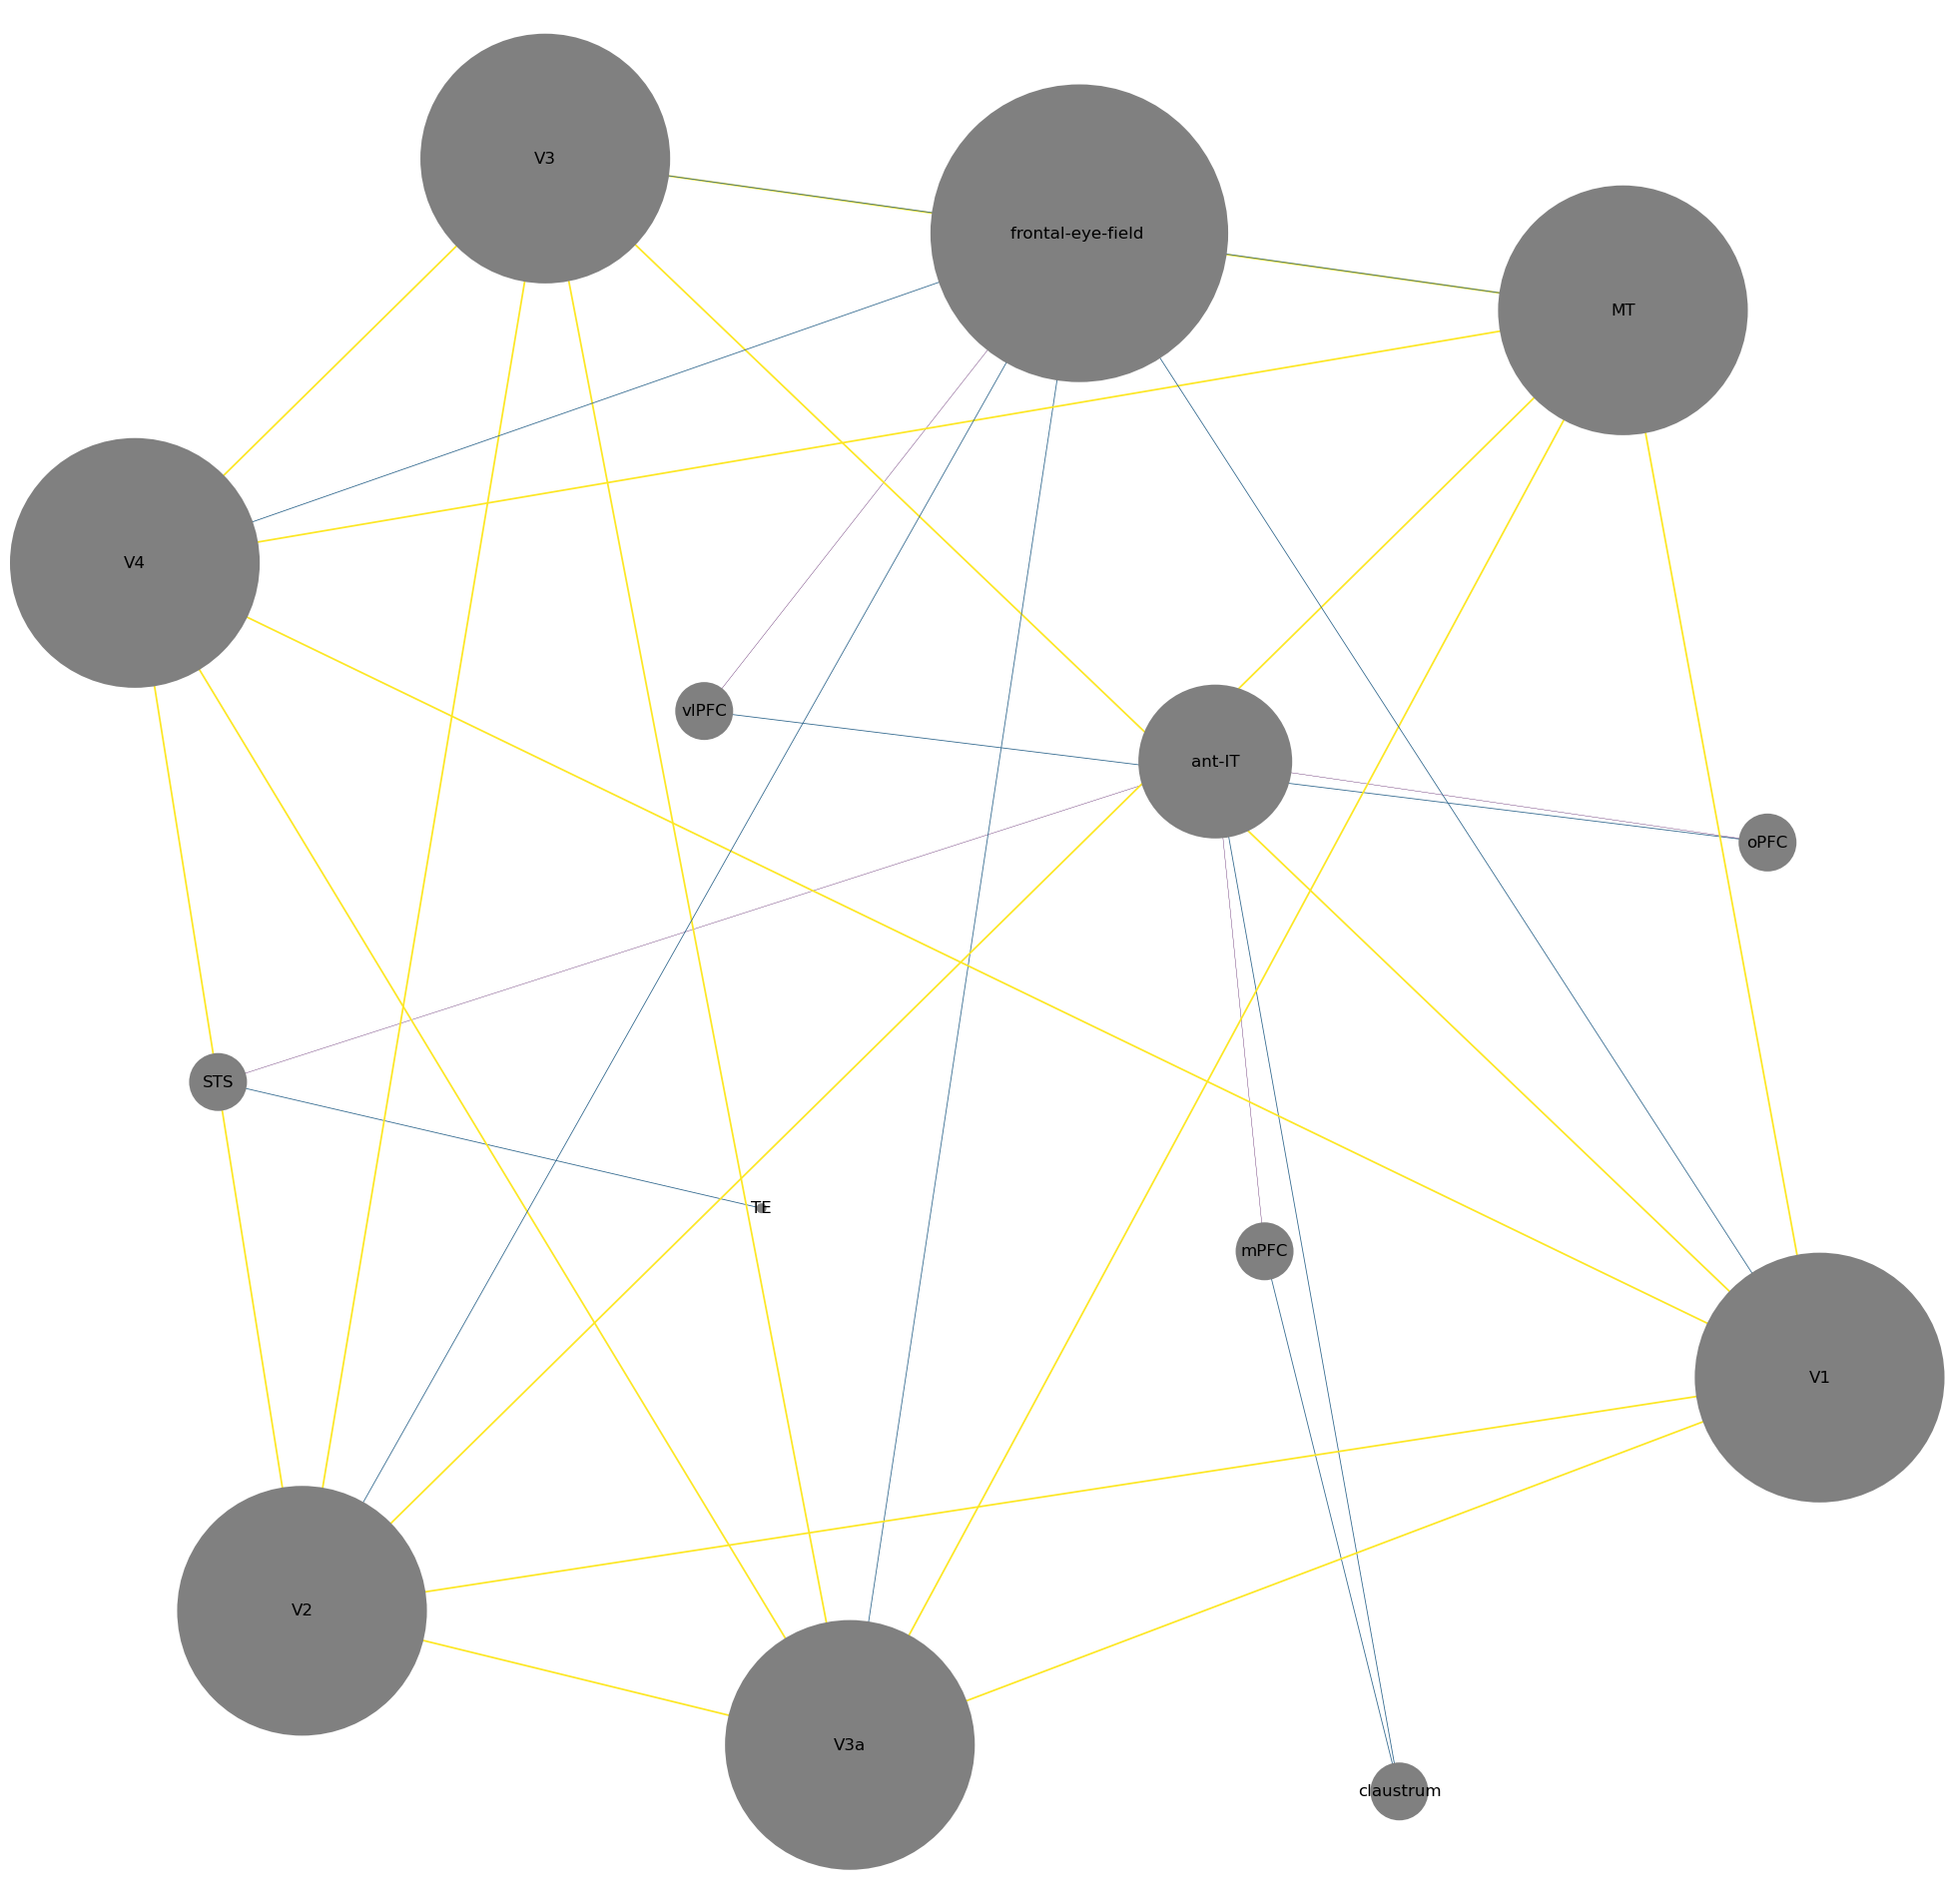

In [116]:
drawing = gr.layouts.render._draw_graph(undirected_connectome, layout, node_colors, 1.,
                                        edge_line_width=edge_widths,
                                        edge_alpha=1.,
                                        edge_colors=edge_colors,
                                        labels=labels,
                                        figure_width=25,
                                        figure_height=25)

In [80]:
# now try with dyloc
beta = '../MTurk1/subjects/wooster/analysis/dyloc_subject_betas.nii'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())[:, :, :, 1:-1]

In [81]:
dyloc_correlation_adj, roi_idxs, dyloc_rdms, dyloc_pvals = geo.pairwise_rsa(beta, np.array(roi_atlas.get_fdata()))

Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(2, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(3, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(4, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(5, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(6, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(7, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(8, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(9, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(10, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(11, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(12, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(13, dtype=torch.int32)


In [82]:
# get adjacency matrix names
roi_names = {i:lookup.loc[idx.item()]['Label Name:'] for i, idx in enumerate(roi_idxs)}

In [99]:
dyloc_roi_corr_graph = nx.from_numpy_array(np.array(dyloc_correlation_adj), create_using=nx.Graph)
# roi_atlas = roi_atlas.get_fdata()
for node in dyloc_roi_corr_graph.nodes():
    dyloc_roi_corr_graph.nodes[node]['roi_name'] = roi_names[node]
    dyloc_roi_corr_graph.nodes[node]['rdm'] = dyloc_rdms[node].tolist()
    dyloc_roi_corr_graph.nodes[node]['num_dims'] = np.count_nonzero(roi_atlas==roi_idxs[node].item())

In [105]:

for node in dyloc_roi_corr_graph.nodes():
    dyloc_roi_corr_graph.nodes[node]['roi_name'] = roi_names[node]
for s, t, data in list(dyloc_roi_corr_graph.edges(data=True)):
    if (dyloc_pvals[s, t] > .1 or data['weight'] < .8) and data['weight'] < .9:
        dyloc_roi_corr_graph.remove_edge(s, t)
GraphIO.dump(dyloc_roi_corr_graph, "../MTurk1/misc_testing_files/dyloc_rep_geo_corr_graph_thresholded.json")

In [106]:
# rep graph
pos_graph = dyloc_roi_corr_graph.copy()
for s, t, data in pos_graph.edges(data=True):
    pos_graph.edges[(s, t)]['weight'] = np.abs(data['weight'])
dyloc_undirected_connectome, layout = gr.layouts.layout_tsne(pos_graph,
                                                       perplexity=100,
                                                       n_iter=10000)
for s, t, data in dyloc_undirected_connectome.edges(data=True):
    dyloc_undirected_connectome.edges[(s, t)]['weight'] = dyloc_roi_corr_graph.edges[(s, t)]['weight']

/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:44: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:60: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


In [107]:
for i in range(len(layout)):
    new_data = gr.layouts.classes.NodePosition(node_id=int(layout[i].node_id),
                                               x=layout[i].x,
                                               y=layout[i].y,
                                               size=layout[i].size,
                                               community=layout[i].community)
    layout[i] = new_data
cmap = plt.get_cmap('viridis')

raw_edge_weights = np.array([edge[2]['weight'] for edge in dyloc_undirected_connectome.edges(data=True)])
edge_weights = raw_edge_weights - min(raw_edge_weights)
edge_weights = edge_weights / max(edge_weights)

edge_colors = np.array([cmap(val) for val in edge_weights])

edge_widths = np.abs(raw_edge_weights) - np.min(raw_edge_weights)
edge_widths = edge_widths / max(edge_widths)
edge_widths = (1. * edge_widths) + .25

node_colors = ['#808080'] * len(dyloc_undirected_connectome.nodes())
labels = {}
for n in dyloc_undirected_connectome.nodes:
    if 'roi_name' in dyloc_undirected_connectome.nodes[n]:
        labels[n] = dyloc_undirected_connectome.nodes[n]['roi_name']
    else:
        labels[n] = 'unnamed'

In [108]:
# add edge colors
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r*255), int(g*255), int(b*255))

for i, edge in enumerate(dyloc_undirected_connectome.edges()):
    s, t = edge
    dyloc_undirected_connectome.edges[(s, t)]['color'] = rgb_to_hex(edge_colors[i][0], edge_colors[i][1], edge_colors[i][2])
    dyloc_undirected_connectome.edges[(s, t)]['width'] = edge_widths[i]
for i, n in enumerate(dyloc_undirected_connectome.nodes()):
    dyloc_undirected_connectome.nodes[n]['graphics'] = {'x': layout[i].x,
                                                  'y': layout[i].y,
                                                  'w': layout[i].size,
                                                  'h': layout[i].size}

nx.readwrite.write_gml(dyloc_undirected_connectome, '../MTurk1/misc_testing_files/dyloc_rep_geo_corr_graph_threshold.gml' )

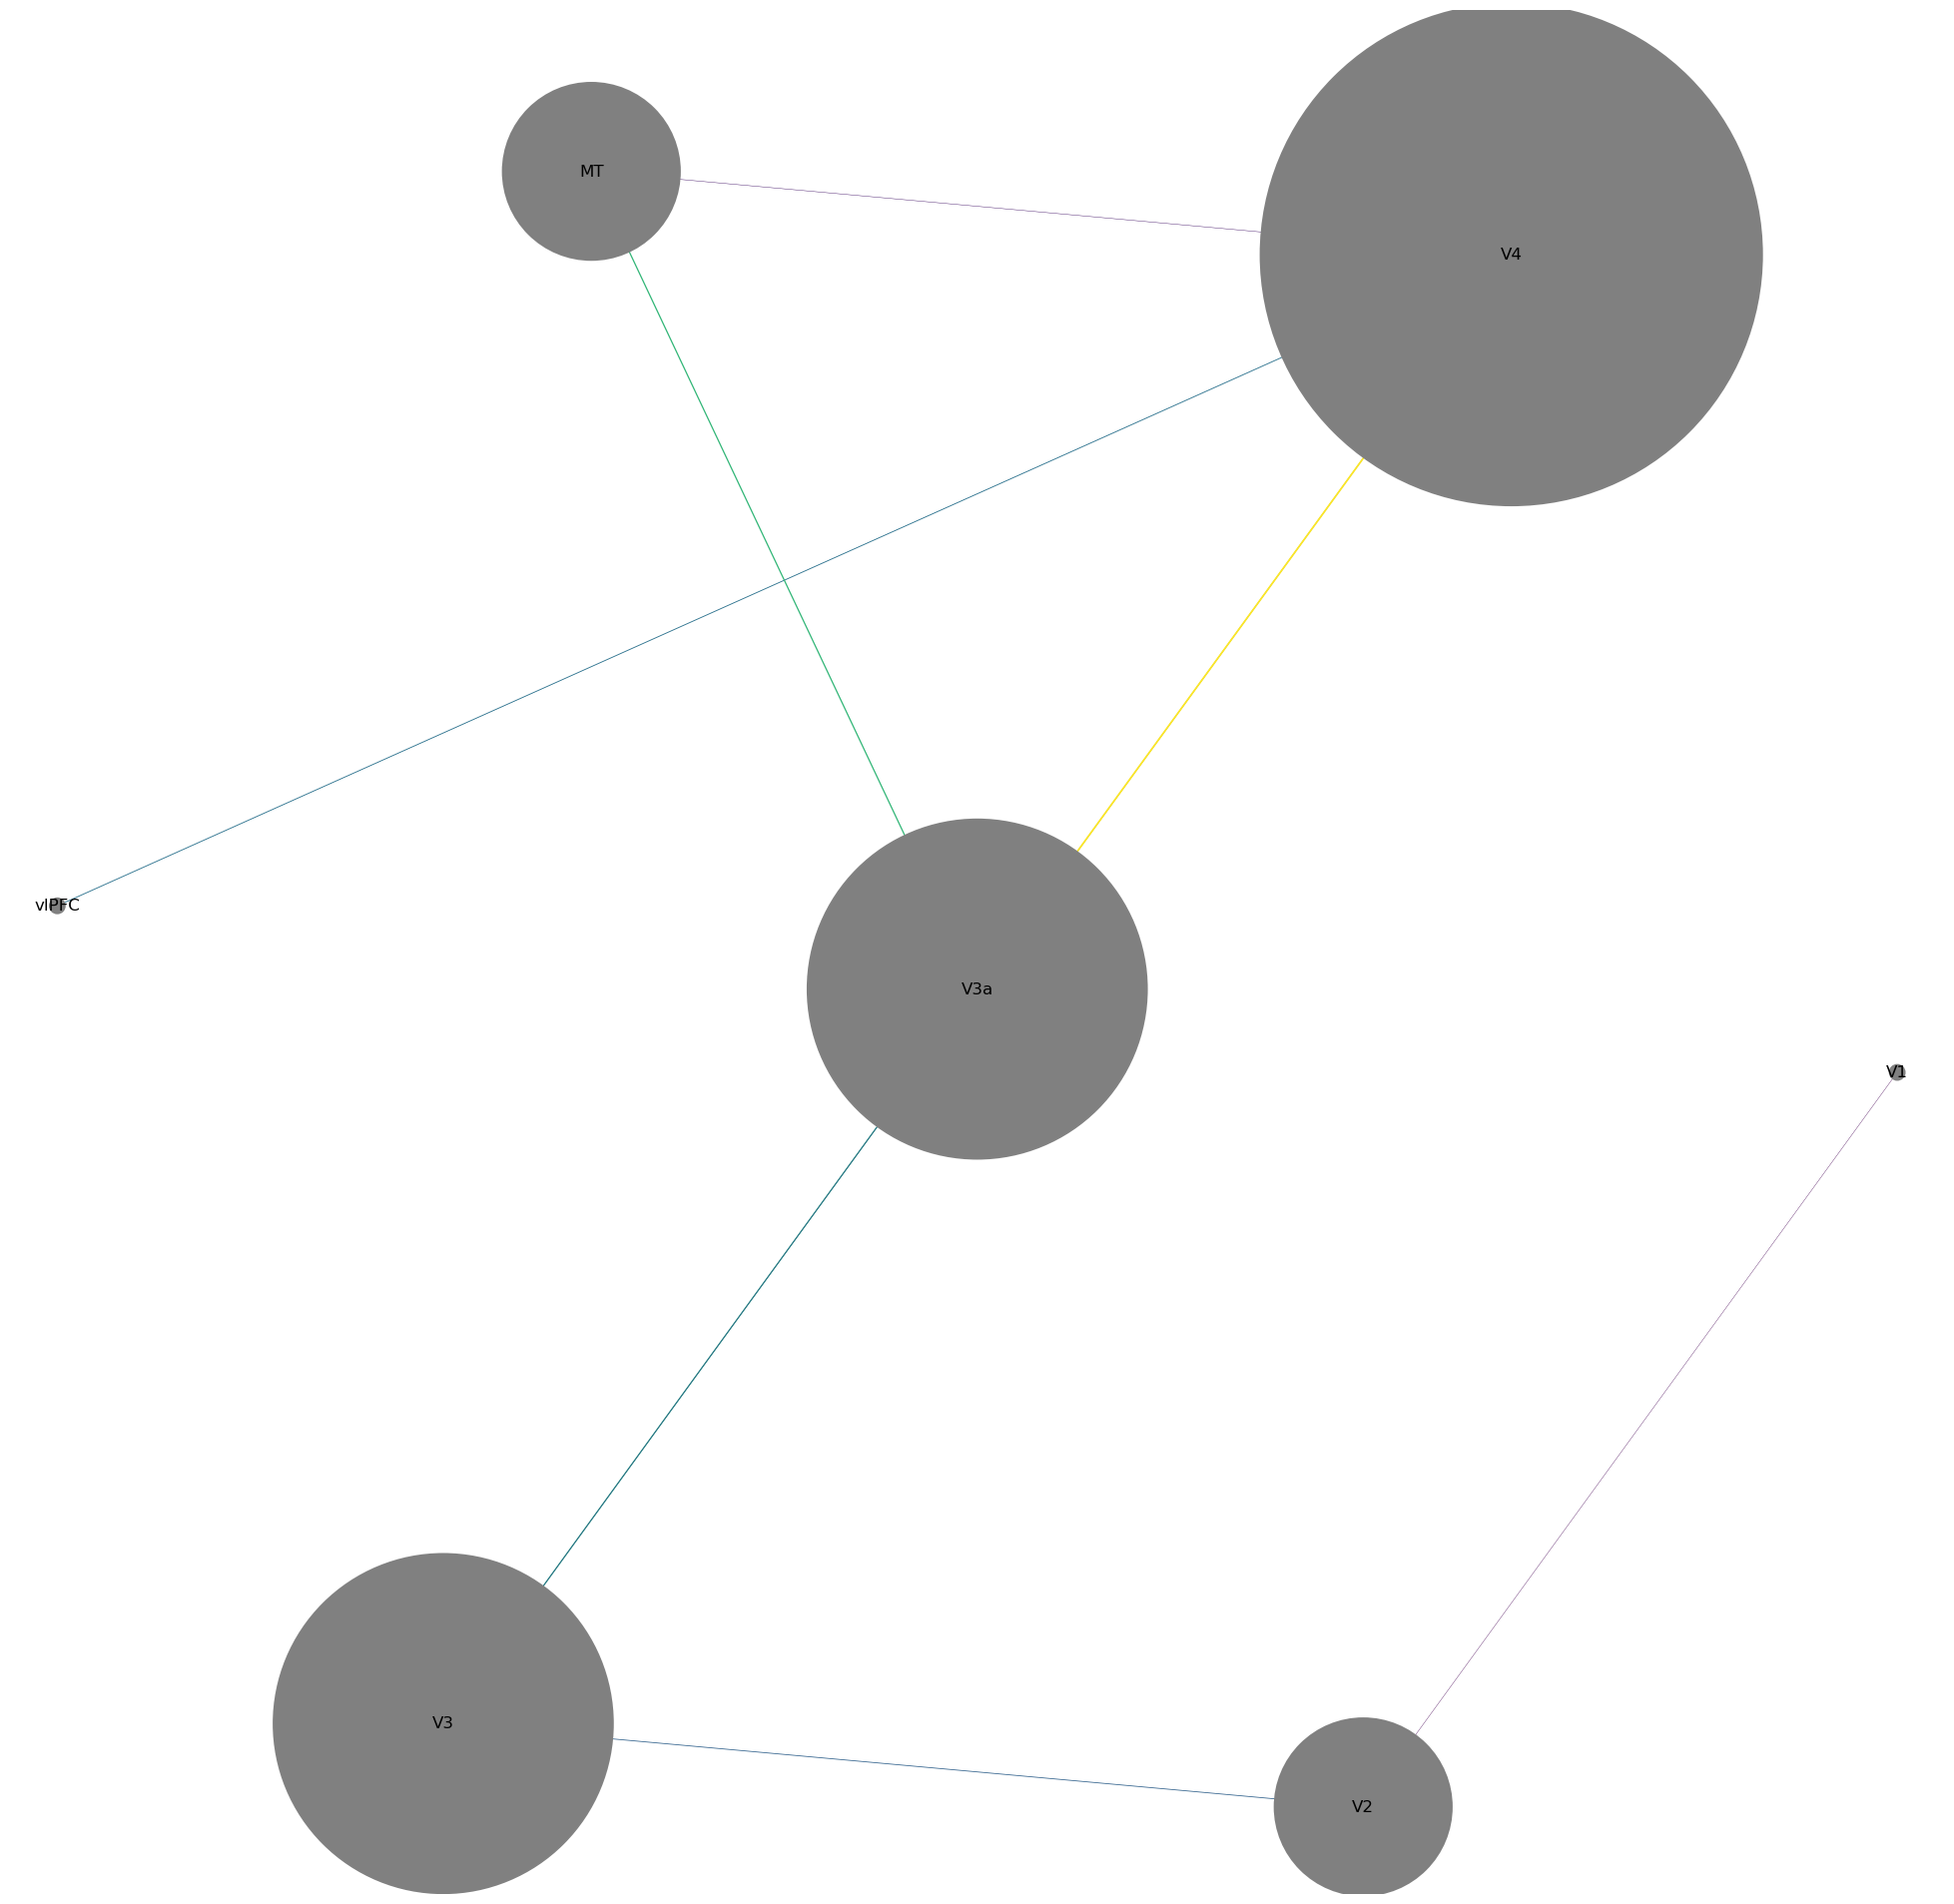

In [109]:
drawing = gr.layouts.render._draw_graph(dyloc_undirected_connectome, layout, node_colors, 1.,
                                        edge_line_width=edge_widths,
                                        edge_alpha=1.,
                                        edge_colors=edge_colors,
                                        labels=labels,
                                        figure_width=25,
                                        figure_height=25)

In [47]:
structure = nx.compose(roi_corr_graph, dyloc_roi_corr_graph)